# Comparison to Razor Blade Method

**Scott Prahl**

**Sept 2023**

In the past, translating a razor blade across a laser beam was the standard method for measuring a beam diameter. The total power would be measured for each position of the razor blade as it occluded the beam.  The beam diameter could be found from a plot of the power versus position.  See, for example,

[Khosrofian and Garetz, "Measurement of a Gaussian laser beam diameter through the direct inversion of knife-edge data", *Applied Optics*, **22**, 3406-3410, (1983).](https://doi.org/10.1364/AO.22.003406)

In this notebook, we compare the results from `lbs.beam_size()` with that from a fit to a simulated razor blade experiment done on the same image.


In [1]:
import imageio.v3 as iio
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
import laserbeamsize as lbs

pixel_size_mm = 3.75 / 1000  # pixel size in mm for the camera
repo = "https://github.com/scottprahl/laserbeamsize/raw/main/docs/"

## The fundamental mode TEM$_{00}$

The lowest order Hermite polynomials, $H_0(x)=1$ (and generalized Laguerre polynomials $L_0^0(x)=1$) are simply constants, so the fundamental ($m=0, n=0$) mode is a Gaussian.  The electric field $\mathcal{E}$ is

$$
\mathcal{E}_{00}(x,y,z) \propto e^{−(x^2+y^2)/w^2} e^{−ik(x^2+y^2)/2R(z)} e^{i(\omega t−kz+\phi)}
$$

The irradiance $E_{00}(x,y,z)$ at a given point in space is defined as the power per unit area in a plane perpendicular to the direction of propagation. It is proportional to the square of the electric field

$$
E_{00}(x,y,z)\propto \mathcal{E}_{00}\cdot \mathcal{E}_{00}^* = E_{00} e^{−2(x^2+y^2)/w^2}
$$

and the proportionality constant $E_{00}$ can be expressed in terms of the total power $P_{00}$ of the beam by requiring the integral of the irradiance over $x$ and $y$ to equal $P_{00}$

$$
E_{00} = {2P_0\over\pi w^2}
$$

## Razor Blade Test

<img src="https://omlc.org/~prahl/host/451/week3/razor.png" width="30%">

If the beam is partially blocked (e.g., with a razor blade that stops all light with $x>x'$), then the power reaching the detector is

$$
P(x')=E_{00}\int_{-\infty}^{x'} e^{−2x^2/w^2}d_major \int_{-\infty}^\infty e^{−2y^2/w^2}d_minor
$$

and the normalized power reaching the detector is

$$
\frac{P(x')}{P}=\frac{1}{2}\left[1+\mathrm{erf}\left(\frac{\sqrt{2}(x'-x_0)}{w}\right)\right]
$$

where $\mathrm{erf}()$ denotes the error function.  The beam radius $w$ is found by fitting to the above expression. 

### Sample Data

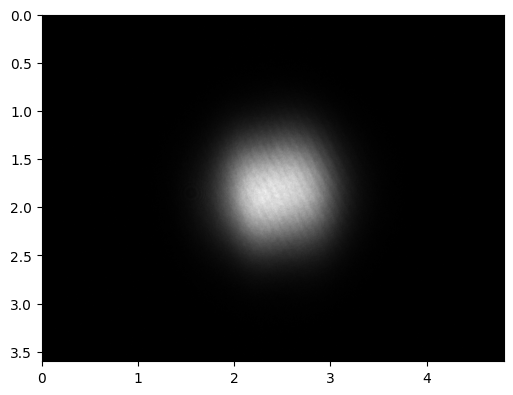

In [2]:
beam = iio.imread(repo + "t-hene.pgm")

ym, xm = beam.shape
plt.imshow(beam, extent=[0, xm * pixel_size_mm, ym * pixel_size_mm, 0], cmap="gray")
plt.show()

### Simulated Horizontal Razor Blade Movement

Just use the image to figure out what the measured power would be for each position of the blade.

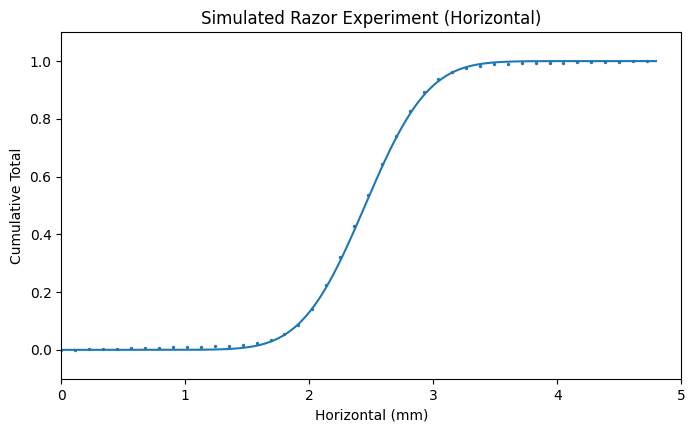

In [3]:
v, h = beam.shape
xval = pixel_size_mm * np.arange(0, h, 1)
s = beam.sum(axis=0).cumsum() / beam.sum()
plt.scatter(xval[::30], s[::30], s=2)

# fit parameters found by trial and error
hw = 0.8
hx0 = 2.45

fit = 0.5 * (1 + scipy.special.erf((-hx0 + xval) * np.sqrt(2) / hw))
plt.plot(xval, fit)
plt.xlabel("Horizontal (mm)")
plt.ylabel("Cumulative Total")
plt.title("Simulated Razor Experiment (Horizontal)")
plt.xlim(0, 5)
plt.ylim(-0.1, 1.1)
plt.show()

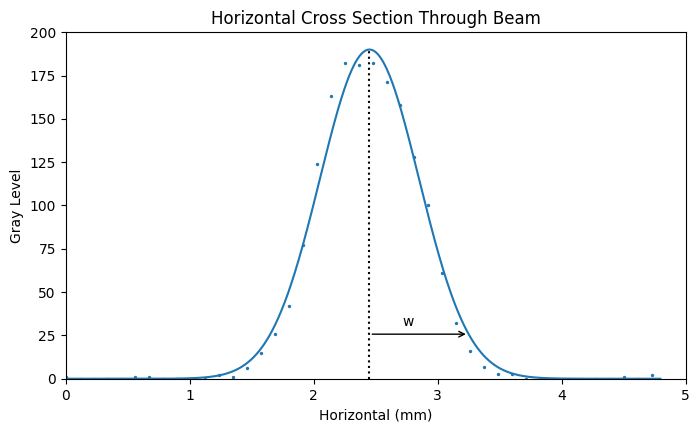

In [4]:
# uses values from previous cell
z = beam[int(v / 2), :]
plt.scatter(xval[::30], z[::30], s=2)

peak = 190
fit = peak * np.exp(-2 * (xval - hx0) ** 2 / hw**2)
plt.plot(xval, fit)

plt.plot([hx0, hx0], [0, peak], ":k")

plt.xlabel("Horizontal (mm)")
plt.ylabel("Gray Level")
plt.title("Horizontal Cross Section Through Beam")
plt.xlim(0, 5)
plt.ylim(0, 200)

ge2 = peak * np.exp(-2)
plt.annotate("w", xy=(hx0 + hw / 3, ge2 + 5))
plt.annotate("", xy=(hx0, ge2), xytext=(hx0 + hw, ge2), arrowprops=dict(arrowstyle="<-"))
plt.show()

### Simulated Vertical Razor Blade Movement

Same as before, but move vertically.

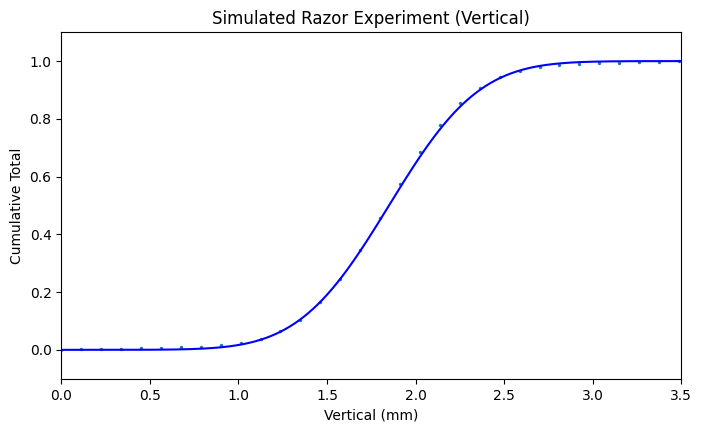

In [5]:
v, h = beam.shape
yval = pixel_size_mm * np.arange(0, v, 1)
s = beam.sum(axis=1).cumsum() / beam.sum()
plt.scatter(yval[::30], s[::30], s=2)

vw = 0.8
vx0 = 1.85

fit = 0.5 * (1 + scipy.special.erf((-vx0 + xval) * np.sqrt(2) / vw))
plt.plot(xval, fit, "b")
plt.xlabel("Vertical (mm)")
plt.ylabel("Cumulative Total")
plt.title("Simulated Razor Experiment (Vertical)")
plt.xlim(0, 3.5)
plt.ylim(-0.1, 1.1)
plt.show()

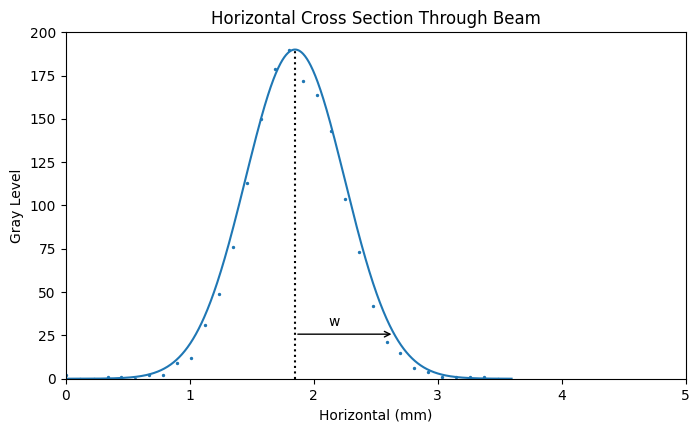

In [6]:
# uses values from previous cell
z = beam[:, int(h / 2)]
plt.scatter(yval[::30], z[::30], s=2)

peak = 190
fit = peak * np.exp(-2 * (yval - vx0) ** 2 / vw**2)
plt.plot(yval, fit)

plt.plot([vx0, vx0], [0, peak], ":k")

plt.xlabel("Horizontal (mm)")
plt.ylabel("Gray Level")
plt.title("Horizontal Cross Section Through Beam")
plt.xlim(0, 5)
plt.ylim(0, 200)

ge2 = peak * np.exp(-2)
plt.annotate("w", xy=(vx0 + vw / 3, ge2 + 5))
plt.annotate("", xy=(vx0, ge2), xytext=(vx0 + vw, ge2), arrowprops=dict(arrowstyle="<-"))
plt.show()

## Beam Radius based on slope

Another method to based on the derivative of the cumulative power.  If the maximum value of this derivative is $\alpha$ then the beam radius is
$$
\alpha =\sqrt{\frac{2}{\pi}} \frac{1}{w}
$$

The advantage here is that not fitting is required.

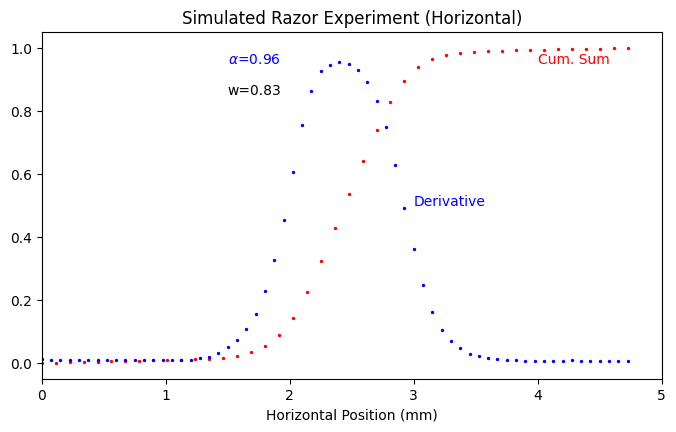

In [7]:
v, h = beam.shape
xval = pixel_size_mm * np.arange(0, h, 1)
s = beam.sum(axis=0).cumsum() / beam.sum()

# this takes the derivative of the cumulative sum with respect to the real position
xderiv = np.gradient(s, xval)
alpha = xderiv.max()
w = 1 / alpha * np.sqrt(2 / np.pi)

plt.scatter(xval[::30], s[::30], s=2, color="red")
plt.scatter(xval[::20], xderiv[::20], s=2, color="blue")

plt.xlabel("Horizontal Position (mm)")
plt.ylabel("")
plt.title("Simulated Razor Experiment (Horizontal)")
plt.annotate("Derivative", xy=(3, 0.5), color="blue")
plt.annotate("Cum. Sum", xy=(4, 0.95), color="red")
plt.annotate(r"$\alpha$=%.2f" % alpha, xy=(1.5, 0.95), color="blue")
plt.annotate("w=%.2f" % w, xy=(1.5, 0.85), color="black")

plt.xlim(0, 5)
plt.ylim(-0.05, 1.05)
plt.show()

## `lbs.beam_size()` comparison

The results are not exactly the same, but close.  The centers match perfectly.  The razor blade technique tends to return slightly larger beam radii than the `lbs` method.

In [8]:
xc, yc, d_major, d_minor, phi = lbs.beam_size(beam)
lbs_xc = xc * pixel_size_mm
lbs_yc = yc * pixel_size_mm

lbs_wx = d_major * pixel_size_mm / 2
lbs_wy = d_minor * pixel_size_mm / 2

print("value   razor   lbs")
print("        [mm]    [mm]")

print("  xc    %.2f    %.2f" % (hx0, lbs_xc))
print("  yc    %.2f    %.2f" % (vx0, lbs_yc))
print()
print("  wx    %.2f    %.2f" % (hw, lbs_wx))
print("  yx    %.2f    %.2f" % (vw, lbs_wy))

value   razor   lbs
        [mm]    [mm]
  xc    2.45    2.44
  yc    1.85    1.84

  wx    0.80    0.69
  yx    0.80    0.65
